# DenseNet模型

DenseNet模型，它的基本思路与ResNet一致，但是它建立的是前面所有层与后面层的密集连接（dense connection），它的名称也是由此而来。DenseNet的另一大特色是通过特征在channel上的连接来实现特征重用（feature reuse）。

DenseNet的基本思路与ResNet一致，但是它建立的是前面所有层与后面层的密集连接（dense  connection），它的名称也是由此而来。DenseNet的另外一大特色是通过特征在channel上的连接来实现特征重用（feature  reuse）。这些特点让DenseNet在参数和计算成本更少的情形下实现比ResNet更优的性能。

相比ResNet，DenseNet提出了一个更激进的密集连接机制：即互相连接所有的层，具体来说就是每个层都会接受其前面所有层作为其额外的输入。ResNet是每个层与前面的某层（一般是2~3层）短路连接在一起，连接方式是通过元素级相加。而在DenseNet中，每个层都会与前面所有层在 channel维度上连接（Concat）在一起（这里各个层的特征图大小是相同的，后面会说明），并作为下一层的输入。对于一个 L 层的网络，DenseNet共包含L*(L+1)/2 个连接，相比ResNet，这是一种密集连接。而且DenseNet是直接Concat来自不同层的特征图，这可以实现特征重用，提高效率，这一特点是DenseNet和ResNet最主要的区别。

需要明确一点，Dense connectivity 仅仅是在一个 Dense Block 里的，不同 Dense Block 之间是没有Dense  Connectivity的。

对比于ResNet的Residual Block，创新性的提出Dense Block，在每一个Dense Block中，任何两层之间都有直接的链接，也就是说，网络每一层的输入都是前面所有层输出的并集

DenseNet的密集链接方式需要特征图大小保持一致，为了解决这个问题，DenseNet在每一个Dense Block的后面都加了一个transition layer，这个layer的作用是改变特征图的大小，具体是通过BN、ReLU和1x1的卷积层以及2x2的平均池化层实现的。另外，transition layer的卷积层会减少特征图的channel数，防止后续层特征图过多。

[GitHub](https://github.com/liuzhuang13/DenseNet)

![DenseNet.png](./imgs/DenseNet.png)

**DenseNet结构**

![DenseNets.png](./imgs/DenseNets.png)

In [1]:
import torch
from torch.utils import data
from PIL import Image   #  pip install pillow
import numpy as np
from torchvision import transforms
import matplotlib.pyplot as plt
%matplotlib inline
import glob

In [2]:
# 获取所有图片路径
all_imgs_path = glob.glob(r'./dataset/birds/*/*.jpg')
all_imgs_path[:3]

['./dataset/birds\\001.Black_footed_Albatross\\Black_Footed_Albatross_0001_796111.jpg',
 './dataset/birds\\001.Black_footed_Albatross\\Black_Footed_Albatross_0002_55.jpg',
 './dataset/birds\\001.Black_footed_Albatross\\Black_Footed_Albatross_0003_796136.jpg']

In [3]:
# 尝试分离出标签
img_p = all_imgs_path[100]
print(repr(img_p))               # repr() 函数返回一个对象的string格式，避免转义字符
print(img_p.split('\\')[1].split('.')[1])

'./dataset/birds\\002.Laysan_Albatross\\Laysan_Albatross_0075_668.jpg'
Laysan_Albatross


In [4]:
# 获取所有图片的标签
label_names = [img_p.split('\\')[1].split('.')[1] for img_p in all_imgs_path]
print(label_names[:5])

# 标签去重
unique_label = np.unique(label_names)
print(unique_label[:5])

# 标签编码
label_to_index = dict((v, k) for k, v in enumerate(unique_label))
print("label_to_index: ", label_to_index)

# 标签解码
# index_to_label = dict((k, v) for k, v in enumerate(unique_label))
index_to_label = dict((v, k) for k, v in label_to_index.items())
print("index_to_label: ",index_to_label)

# 将所有的图片标签转换为数字
all_labels = [label_to_index.get(name) for name in label_names]
print(all_labels[:5])

# 查看数据集大小
print(len(all_imgs_path))

['Black_footed_Albatross', 'Black_footed_Albatross', 'Black_footed_Albatross', 'Black_footed_Albatross', 'Black_footed_Albatross']
['Acadian_Flycatcher' 'American_Crow' 'American_Goldfinch'
 'American_Pipit' 'American_Redstart']
label_to_index:  {'Acadian_Flycatcher': 0, 'American_Crow': 1, 'American_Goldfinch': 2, 'American_Pipit': 3, 'American_Redstart': 4, 'American_Three_toed_Woodpecker': 5, 'Anna_Hummingbird': 6, 'Artic_Tern': 7, 'Baird_Sparrow': 8, 'Baltimore_Oriole': 9, 'Bank_Swallow': 10, 'Barn_Swallow': 11, 'Bay_breasted_Warbler': 12, 'Belted_Kingfisher': 13, 'Bewick_Wren': 14, 'Black_Tern': 15, 'Black_and_white_Warbler': 16, 'Black_billed_Cuckoo': 17, 'Black_capped_Vireo': 18, 'Black_footed_Albatross': 19, 'Black_throated_Blue_Warbler': 20, 'Black_throated_Sparrow': 21, 'Blue_Grosbeak': 22, 'Blue_Jay': 23, 'Blue_headed_Vireo': 24, 'Blue_winged_Warbler': 25, 'Boat_tailed_Grackle': 26, 'Bobolink': 27, 'Bohemian_Waxwing': 28, 'Brandt_Cormorant': 29, 'Brewer_Blackbird': 30, 'Brew

In [5]:
# 数据集划分，将图片和标签进行同步的乱序
np.random.seed(2021)        # 随机种子，保证每次划分结果一致
random_index = np.random.permutation(len(all_imgs_path))    # 创建与数据集等长的乱序索引random_index
all_imgs_path = np.array(all_imgs_path)[random_index]    # 对图片使用random_index进行索引
all_labels = np.array(all_labels)[random_index]          # 对标签使用random_index进行索引

# 划分训练集和测试集，训练集占80%，测试集占20%
s = int(len(all_imgs_path)*0.8)
print(s)
train_imgs = all_imgs_path[:s]
train_labels = all_labels[:s]
test_imgs = all_imgs_path[s:]
test_labels = all_labels[s:]

9430


In [8]:
# 图片变换
transform = transforms.Compose([
                    transforms.Resize((224, 224)),
                    transforms.ToTensor(),
])

In [23]:
class Mydataset(data.Dataset):
    def __init__(self, img_paths, labels):
        self.imgs = img_paths
        self.labels = labels
        
    def __getitem__(self, index):
        img = self.imgs[index]
        label = self.labels[index]
        
        pil_img = Image.open(img)
        img_data = np.asarray(pil_img, dtype=np.uint8)
        if len(img_data.shape) == 2:
            img_data = np.repeat(img_data[:, :, np.newaxis], 3, axis=2)
        
        img_data = transform(Image.fromarray(img_data))
        
        return img_data, label
    
    def __len__(self):
        return len(self.imgs)

In [24]:
train_ds = Mydataset(train_path, train_labels)
test_ds = Mydataset(test_path, test_labels)

In [25]:
BATCH_SIZE = 32

In [26]:
train_dl = data.DataLoader(
                      train_ds,
                      batch_size=BATCH_SIZE,
)

In [27]:
test_dl = data.DataLoader(test_ds,
                          batch_size=BATCH_SIZE)

In [28]:
imgs_batch, labels_batch = next(iter(train_dl))

In [29]:
imgs_batch.shape

torch.Size([32, 3, 224, 224])

In [30]:
labels_batch.shape

torch.Size([32])

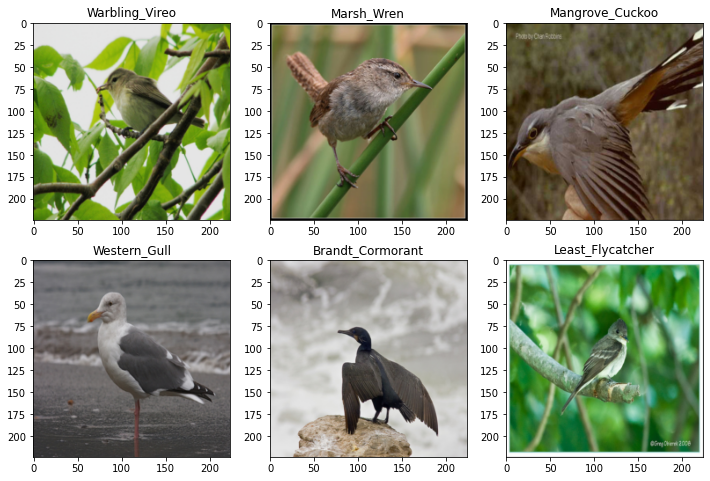

In [31]:
plt.figure(figsize=(12, 8))

for i, (img, label) in enumerate(zip(imgs_batch[-6:], labels_batch[-6:])):
    img = img.permute(1, 2, 0).numpy()
    plt.subplot(2, 3, i+1)
    plt.title(index_to_label.get(label.item()))
    plt.imshow(img)

In [32]:
my_densenet = torchvision.models.densenet121(pretrained=True).features

In [33]:
if torch.cuda.is_available():
    my_densenet = my_densenet.cuda()

In [34]:
for p in my_densenet.parameters():
    p.requires_grad = False

### 提取DenseNet特征

In [35]:
train_labels = []
train_features = []

for im,la in train_dl:
    o = my_densenet(im.cuda())
    o = o.view(o.size(0),-1)
    train_labels.extend(la)
    train_features.extend(o.cpu().data)


test_labels = []
test_features = []

for im,la in test_dl:
    o = my_densenet(im.cuda())
    o = o.view(o.size(0),-1)
    test_labels.extend(la)
    test_features.extend(o.cpu().data)

In [36]:
class FeaturesDataset(data.Dataset):
    def __init__(self, featlst, labellst):
        self.featlst = featlst
        self.labellst = labellst
    def __getitem__(self, index):
        return (self.featlst[index], self.labellst[index])
    def __len__(self):
        return len(self.labellst)

In [37]:
train_feat_ds = FeaturesDataset(train_features, train_labels)
test_feat_ds = FeaturesDataset(test_features, test_labels)

In [38]:
train_feat_dl = data.DataLoader(train_feat_ds, batch_size=64, shuffle=True)
test_feat_dl = data.DataLoader(test_feat_ds,batch_size=64)

In [39]:
class FCModel(torch.nn.Module):
    def __init__(self, in_size, out_size):
        super().__init__()
        self.fc = torch.nn.Linear(in_size, out_size)

    def forward(self,inp):
        out = self.fc(inp)
        return out

In [40]:
fc_in_size = train_features[0].shape[0]
out_class = 200

In [41]:
net = FCModel(fc_in_size, out_class)

In [42]:
if torch.cuda.is_available():
    net.to('cuda')

In [43]:
loss_fn = torch.nn.CrossEntropyLoss()
optim = torch.optim.Adam(net.parameters(), lr=0.00001)

In [44]:
def fit(epoch, model, trainloader, testloader):
    correct = 0
    total = 0
    running_loss = 0
    
    model.train()
    for x, y in trainloader:
        if torch.cuda.is_available():
            y = torch.tensor(y, dtype=torch.long)
            x, y = x.to('cuda'), y.to('cuda')
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        optim.zero_grad()
        loss.backward()
        optim.step()
        with torch.no_grad():
            y_pred = torch.argmax(y_pred, dim=1)
            correct += (y_pred == y).sum().item()
            total += y.size(0)
            running_loss += loss.item()
        
    epoch_loss = running_loss / len(trainloader.dataset)
    epoch_acc = correct / total
        
        
    test_correct = 0
    test_total = 0
    test_running_loss = 0 
    
    model.eval()
    with torch.no_grad():
        for x, y in testloader:
            y = torch.tensor(y, dtype=torch.long)
            if torch.cuda.is_available():
                x, y = x.to('cuda'), y.to('cuda')
            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            y_pred = torch.argmax(y_pred, dim=1)
            test_correct += (y_pred == y).sum().item()
            test_total += y.size(0)
            test_running_loss += loss.item()
    
    epoch_test_loss = test_running_loss / len(testloader.dataset)
    epoch_test_acc = test_correct / test_total
    
        
    print('epoch: ', epoch, 
          'loss： ', round(epoch_loss, 3),
          'accuracy:', round(epoch_acc, 3),
          'test_loss： ', round(epoch_test_loss, 3),
          'test_accuracy:', round(epoch_test_acc, 3)
             )
        
    return epoch_loss, epoch_acc, epoch_test_loss, epoch_test_acc

In [45]:
epochs = 50

In [46]:
train_loss = []
train_acc = []
test_loss = []
test_acc = []

for epoch in range(epochs):
    epoch_loss, epoch_acc, epoch_test_loss, epoch_test_acc = fit(epoch,
                                                                 net,
                                                                 train_feat_dl,
                                                                 test_feat_dl)
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)
    test_loss.append(epoch_test_loss)
    test_acc.append(epoch_test_acc)

<ipython-input-44-50b0957f54a0>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.long)
<ipython-input-44-50b0957f54a0>:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.long)


epoch:  0 loss：  0.071 accuracy: 0.116 test_loss：  0.056 test_accuracy: 0.267
epoch:  1 loss：  0.039 accuracy: 0.578 test_loss：  0.041 test_accuracy: 0.437
epoch:  2 loss：  0.023 accuracy: 0.813 test_loss：  0.035 test_accuracy: 0.518
epoch:  3 loss：  0.015 accuracy: 0.913 test_loss：  0.031 test_accuracy: 0.548
epoch:  4 loss：  0.01 accuracy: 0.964 test_loss：  0.029 test_accuracy: 0.569
epoch:  5 loss：  0.007 accuracy: 0.986 test_loss：  0.027 test_accuracy: 0.582
epoch:  6 loss：  0.005 accuracy: 0.994 test_loss：  0.026 test_accuracy: 0.594
epoch:  7 loss：  0.004 accuracy: 0.998 test_loss：  0.026 test_accuracy: 0.605
epoch:  8 loss：  0.003 accuracy: 0.999 test_loss：  0.025 test_accuracy: 0.609
epoch:  9 loss：  0.002 accuracy: 1.0 test_loss：  0.025 test_accuracy: 0.608
epoch:  10 loss：  0.002 accuracy: 1.0 test_loss：  0.024 test_accuracy: 0.616
epoch:  11 loss：  0.001 accuracy: 1.0 test_loss：  0.024 test_accuracy: 0.616
epoch:  12 loss：  0.001 accuracy: 1.0 test_loss：  0.024 test_accuracy

In [71]:
import random
r_index = random.choice(range(len(test_feat_ds)))

In [72]:
img_tensor, real_label = test_feat_ds[r_index]

In [74]:
img_tensor.cuda()

RuntimeError: CUDA error: an illegal memory access was encountered

In [73]:
pred = net(img_tensor.cuda())

RuntimeError: CUDA error: an illegal memory access was encountered